In [6]:
import pandas as pd
import numpy as np

In [7]:
df = pd.read_csv('twitter_cleaned.csv')

## Tag sentiments using TextBlob

In [8]:
!pip install textblob

     |████████████████████████████████| 636 kB 3.5 MB/s eta 0:00:01
     |████████████████████████████████| 1.4 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 856 kB/s  eta 0:00:01
     |████████████████████████████████| 661 kB 30.2 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 3.3 MB/s  eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434675 sha256=7cf03b3b5c04ee29f499cf19c91512d33312708ae19a656d3bed9709179968a4
  Stored in directory: /home/jovyan/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built nltk


In [ ]:
!pip install emoji

In [10]:
from textblob import TextBlob
import emoji
import re

In [11]:
def clean_tweet(tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
        
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [12]:
df['clean_text'] = df['text'].apply(clean_tweet).apply(emoji.demojize)

In [13]:
df['sentiment'] = df['clean_text'].apply(analyze_sentiment)

In [15]:
candidates=pd.read_csv('agg_candidate.csv')[['#', 'candidate']]

In [16]:
twit_sent = df.merge(candidates, left_on='candidate_num', right_on='#')

In [18]:
twit_sent = twit_sent[['candidate','tweet_id', 'text','clean_text',
       'sentiment']].drop_duplicates(subset=['candidate','tweet_id', 'text','clean_text'], keep='first')

In [19]:
twit_sent.to_csv('TextBlob_Sentiment.csv') #backup

__Observation__: There are a lot of misclassified posts from those tagged as neutral. Try translating them to english then re-classify.

In [20]:
twit_neu = twit_sent[twit_sent['sentiment']==0]

In [22]:
import googletrans
from googletrans import Translator

translator = Translator()

In [0]:
# twit_neu['translated_text'] = twit_neu['text'].apply(str).apply(translator.translate).apply(lambda x: x.text)

In [0]:
trans=[]

for i in range(len(twit_neu)):
    try:
        trans.append(translator.translate(twit_neu.iloc[i]['text']).text)
        print(str(i) + " ok")
    except:
        trans.append(twit_neu.iloc[i]['text'])
        print(str(i) + " can't translate")

In [0]:
twit_neu['translated_text']=trans

In [0]:
twit_neu['clean_text'] = twit_neu['translated_text'].apply(clean_tweet).apply(emoji.demojize)

In [0]:
twit_neu['sentiment2'] = twit_neu['clean_text'].apply(analyze_sentiment)

In [0]:
twit_neu['re-classify'] = twit_neu['sentiment']!=twit_neu['sentiment2']

In [24]:
twit_neu.shape

(135053, 9)

In [25]:
twit_neu.head()

,Unnamed: 0,candidate,tweet_id,text,clean_text,sentiment,translated_text,sentiment2,re-classify
0,0,Vangie Abejo,1095181976808710144,Here is the certified list of senatorial candi...,Here is the certified list of senatorial candi...,0,Here is the certified list of senatorial candi...,0,False
1,1,Vangie Abejo,1103227490221273088,Who is Vangie Abejo 😭😭😭,Who is Vangie Abejo,0,Who is Vangie Abejo 😭😭😭,0,False
2,3,Vangie Abejo,1110857530899464193,"Abejo, Vangie",Abejo Vangie,0,"Abejo, Vangie",0,False
3,4,Vangie Abejo,1112020184208797699,"Inclined not to vote for: ARIAS, MARCELINO CAC...",Inclined not to vote for ARIAS MARCELINO CACER...,0,"Inclined not to vote for: ARIAS, MARCELINO CAC...",0,False
4,6,Vangie Abejo,1122103399904768000,#TheFilipinoVotes #PHVote #Halalan2019 #OtsoDi...,TheFilipinoVotes PHVote Elections2019 OtsoDire...,0,#TheFilipinoVotes #PHVote # Elections2019 #Ots...,1,True


In [26]:
twit_neu.groupby('re-classify')['text'].count()

re-classify
False    115884
True      19169
Name: text, dtype: int64

In [0]:
twit_neu.to_csv('Neutral_Translated.csv') #for checking

__Observation__: A lot of tweets under neutral are still not properly classified

## Sample tweets for manual correction of tagging

In [41]:
for i in twit_sent['sentiment'].unique():
    temp = twit_sent[twit_sent['sentiment']==i]
    print(i, len(temp))

0 167738
-1 24270
1 67021


In [0]:
twit_sample = pd.DataFrame([])

for i in twit_sent['sentiment'].unique():
    temp = twit_sent[twit_sent['sentiment']==i].sample(20303)
    twit_sample=pd.concat([twit_sample,temp])

In [27]:
twit_sample.to_csv('SampledTweets_SentimentAnalysis.csv')

## Text Classification for adjusted sentiment tags

Try to re-model classification.

In [28]:
import nltk
import string
from nltk.stem.wordnet import WordNetLemmatizer

In [31]:
lemmatizer  = WordNetLemmatizer()
stopwords = list(nltk.corpus.stopwords.words('english'))
stopwords2 = set(pd.read_json('node_modules/stopwords-tl/stopwords-tl.json'))
punct = string.punctuation

In [0]:
# stopwords.extend(['lol','haha','hahaha','hahahaha','hahahahaha','ok','okay'])
# stopwords=set(stopwords)

In [32]:
cnd = set(candidates['candidate'].apply(lambda x: x.lower()))

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [34]:
twit_sample_adj = pd.read_csv('SampledTweets_SentimentAnalysis_Adj.csv')

In [35]:
twit_sample_adj.groupby('sentiment')['clean_text'].count()

sentiment
-1    22828
 0    12470
 1    25300
Name: clean_text, dtype: int64

### Try: Oversampling

In [36]:
twit_sample_adj2 = pd.DataFrame([])

for i in twit_sample_adj['sentiment'].unique():
    temp = twit_sample_adj[twit_sample_adj['sentiment']==i].sample(25300, replace=True)
    twit_sample_adj2=pd.concat([twit_sample_adj2,temp])

In [37]:
len(twit_sample_adj2)

75900

In [38]:
twit_adj_processed = []

for tweet in twit_sample_adj2['clean_text'].apply(str):
    result = ""
    for sent in nltk.sent_tokenize(tweet):
        for word in nltk.word_tokenize(sent):
            word = word.lower()
            word = lemmatizer.lemmatize(word)
            if word not in stopwords and word not in punct and word not in stopwords2 and word not in cnd:
                result = result + " " + word
    
    twit_adj_processed.append(result)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(twit_adj_processed, twit_sample_adj2['sentiment'])

count_vectorizer = CountVectorizer().fit(X_train)
X_train_counts = count_vectorizer.transform(X_train)

tfidf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

#### SVM: Linear SVC

In [40]:
!pip install seaborn

     |████████████████████████████████| 215 kB 3.6 MB/s eta 0:00:01


In [42]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
clf = LinearSVC().fit(X_train_tfidf, y_train)

X_test_counts = count_vectorizer.transform(X_test)

X_test_tfidf = tfidf_transformer.transform(X_test_counts)

svm_preds = clf.predict(X_test_tfidf)

In [44]:
print(confusion_matrix(y_test,svm_preds))
print(classification_report(y_test,svm_preds))
print(accuracy_score(y_test, svm_preds))

[[5754  258  264]
 [  93 6161  111]
 [ 287  300 5747]]
              precision    recall  f1-score   support

          -1       0.94      0.92      0.93      6276
           0       0.92      0.97      0.94      6365
           1       0.94      0.91      0.92      6334

    accuracy                           0.93     18975
   macro avg       0.93      0.93      0.93     18975
weighted avg       0.93      0.93      0.93     18975

0.9308036890645587


#### Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train_tfidf, y_train)

rf_preds = text_classifier.predict(X_test_tfidf)

In [46]:
print(confusion_matrix(y_test,rf_preds))
print(classification_report(y_test,rf_preds))
print(accuracy_score(y_test, rf_preds))

[[5671  295  310]
 [  59 6235   71]
 [ 330  271 5733]]
              precision    recall  f1-score   support

          -1       0.94      0.90      0.92      6276
           0       0.92      0.98      0.95      6365
           1       0.94      0.91      0.92      6334

    accuracy                           0.93     18975
   macro avg       0.93      0.93      0.93     18975
weighted avg       0.93      0.93      0.93     18975

0.9295915678524375


#### Multinomial Naive Bayes

In [47]:
twit_sample_adj2_nb = twit_sample_adj2[twit_sample_adj2['sentiment']!=0]

In [48]:
twit_adj_processed_nb = []

for tweet in twit_sample_adj2_nb['clean_text'].apply(str):
    result = ""
    for sent in nltk.sent_tokenize(tweet):
        for word in nltk.word_tokenize(sent):
            word = word.lower()
            word = lemmatizer.lemmatize(word)
            if word not in stopwords and word not in punct and word not in stopwords2 and word not in cnd:
                result = result + " " + word
    
    twit_adj_processed_nb.append(result)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(twit_adj_processed_nb, twit_sample_adj2_nb['sentiment'])

In [50]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])
tuned_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__alpha': [1, 1e-1, 1e-2]
}

In [51]:
clf = GridSearchCV(text_clf, tuned_parameters, cv=10, scoring='roc_auc')
clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [1, 0.1, 0.01],
                         'tfidf__norm': ('l1', 'l2'),
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             scoring='roc_auc')

In [52]:
clf.best_estimator_

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.1))])

In [53]:
text_clf=Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf', MultinomialNB(alpha=0.1))])

clf.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', MultinomialNB())]),
             param_grid={'clf__alpha': [1, 0.1, 0.01],
                         'tfidf__norm': ('l1', 'l2'),
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 2)]},
             scoring='roc_auc')

In [54]:
mnb_preds = clf.predict(X_test)

print(confusion_matrix(y_test,mnb_preds))
print(classification_report(y_test,mnb_preds))
print(accuracy_score(y_test, mnb_preds))

[[5903  489]
 [ 700 5558]]
              precision    recall  f1-score   support

          -1       0.89      0.92      0.91      6392
           1       0.92      0.89      0.90      6258

    accuracy                           0.91     12650
   macro avg       0.91      0.91      0.91     12650
weighted avg       0.91      0.91      0.91     12650

0.90600790513834


### Try: Undersampling

In [55]:
twit_sample_adj3 = pd.DataFrame([])

for i in twit_sample_adj['sentiment'].unique():
    temp = twit_sample_adj[twit_sample_adj['sentiment']==i].sample(12470)
    twit_sample_adj3=pd.concat([twit_sample_adj3,temp])

In [56]:
len(twit_sample_adj3)

37410

In [58]:
twit_adj3_processed = []

for tweet in twit_sample_adj3['clean_text'].apply(str):
    result = ""
    for sent in nltk.sent_tokenize(tweet):
        for word in nltk.word_tokenize(sent):
            word = word.lower()
            word = lemmatizer.lemmatize(word)
            if word not in stopwords and word not in punct:
                result = result + " " + word
    
    twit_adj3_processed.append(result)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(twit_adj3_processed, twit_sample_adj3['sentiment'])

count_vectorizer = CountVectorizer().fit(X_train)
X_train_counts = count_vectorizer.transform(X_train)

tfidf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

#### SVM: Linear SVC

In [60]:
clf = LinearSVC().fit(X_train_tfidf, y_train)

X_test_counts = count_vectorizer.transform(X_test)

X_test_tfidf = tfidf_transformer.transform(X_test_counts)

svm_pred_us = clf.predict(X_test_tfidf)

In [61]:
print(confusion_matrix(y_test,svm_pred_us))
print(classification_report(y_test,svm_pred_us))
print(accuracy_score(y_test, svm_pred_us))

[[2570  267  277]
 [ 165 2757  126]
 [ 271  285 2635]]
              precision    recall  f1-score   support

          -1       0.85      0.83      0.84      3114
           0       0.83      0.90      0.87      3048
           1       0.87      0.83      0.85      3191

    accuracy                           0.85      9353
   macro avg       0.85      0.85      0.85      9353
weighted avg       0.85      0.85      0.85      9353

0.8512776649203464


#### Random Forest Classifier

In [62]:
text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train_tfidf, y_train)

rf_pred_us = text_classifier.predict(X_test_tfidf)

In [64]:
print(confusion_matrix(y_test,rf_pred_us))
print(classification_report(y_test,rf_pred_us))
print(accuracy_score(y_test, rf_pred_us))

[[2281  411  422]
 [ 127 2852   69]
 [ 358  397 2436]]
              precision    recall  f1-score   support

          -1       0.82      0.73      0.78      3114
           0       0.78      0.94      0.85      3048
           1       0.83      0.76      0.80      3191

    accuracy                           0.81      9353
   macro avg       0.81      0.81      0.81      9353
weighted avg       0.81      0.81      0.81      9353

0.8092590612637657


## Sentiment Analysis using Linear SVC

In [65]:
X_train, X_test, y_train, y_test = train_test_split(twit_adj_processed, twit_sample_adj2['sentiment'])

count_vectorizer = CountVectorizer().fit(X_train)
X_train_counts = count_vectorizer.transform(X_train)

tfidf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

In [66]:
clf = LinearSVC().fit(X_train_tfidf, y_train)

X_test_counts = count_vectorizer.transform(X_test)

X_test_tfidf = tfidf_transformer.transform(X_test_counts)

svm_preds = clf.predict(X_test_tfidf)

In [67]:
print(confusion_matrix(y_test,svm_preds))
print(classification_report(y_test,svm_preds))
print(accuracy_score(y_test, svm_preds))

[[5738  253  288]
 [ 103 6148  121]
 [ 302  263 5759]]
              precision    recall  f1-score   support

          -1       0.93      0.91      0.92      6279
           0       0.92      0.96      0.94      6372
           1       0.93      0.91      0.92      6324

    accuracy                           0.93     18975
   macro avg       0.93      0.93      0.93     18975
weighted avg       0.93      0.93      0.93     18975

0.9299077733860343


In [68]:
def plot_coefficients(classifier, feature_names, top_features=20):

    # Access the coefficients from classifier
    coef = classifier.coef_

    # Access the classes
    classes = classifier.classes_

    # Iterate the loop for number of classes
    for i in range(2,3): #positive class


        # print(classes[i])

        # Access the row containing the coefficients for this class
        class_coef = coef[i]


        # Below this, I have just replaced 'i' in your code with 'class_coef'
        # Pass this to get top and bottom features
        top_positive_coefficients = np.argsort(class_coef)[-top_features:]
        top_negative_coefficients = np.argsort(class_coef)[:top_features]

        # Concatenate the above two 
        top_coefficients = np.hstack([top_negative_coefficients, 
                                      top_positive_coefficients])
        # create plot
        sns.set(style="whitegrid", font_scale=1)

        plt.figure(figsize=(15, 6))
        
        colors = ["#FA6E89" if c < 0 else "#00c3b1" for c in class_coef[top_coefficients]]
        plt.bar(np.arange(2 * top_features), class_coef[top_coefficients], color=colors)
        feature_names = np.array(feature_names)

        # Here I corrected the start to 0 (Your code has 1, which shifted the labels)
        plt.xticks(np.arange(0, 1 + 2 * top_features), 
                   feature_names[top_coefficients], rotation=90, ha="right")

        plt.title('Top words driving positive-negative sentiments')
        plt.savefig('figures/sentiment_drivers.png', dpi=200)
        plt.show()

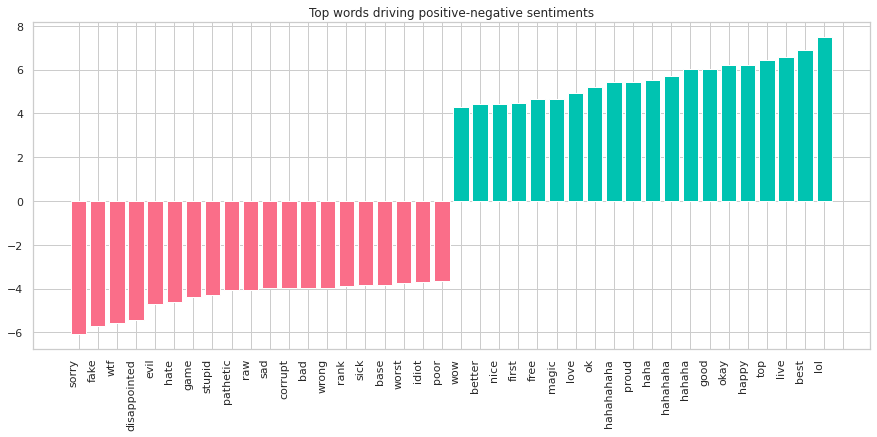

In [69]:
plot_coefficients(clf, count_vectorizer.get_feature_names(),20)

### Evaluate the rest of the data

In [70]:
twit_cl = pd.concat([twit_sent, twit_sample]).drop_duplicates(subset='tweet_id', keep=False)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [71]:
len(twit_sent), len(twit_sample_adj), len(twit_cl), len(twit_sample_adj)+len(twit_cl)

(259029, 60909, 132213, 193122)

In [72]:
twit_cl_processed = []

for tweet in twit_cl['clean_text'].apply(str):
    result = ""
    for sent in nltk.sent_tokenize(tweet):
        for word in nltk.word_tokenize(sent):
            word = word.lower()
            word = lemmatizer.lemmatize(word)
            if word not in stopwords and word not in punct and word not in stopwords2 and word not in cnd:
                result = result + " " + word
    
    twit_cl_processed.append(result)

In [73]:
X_cl_counts = count_vectorizer.transform(twit_cl_processed)
X_cl_tfidf = tfidf_transformer.transform(X_cl_counts)
svm_preds_cl = clf.predict(X_cl_tfidf)

In [74]:
twit_cl['sentiment2'] = svm_preds_cl

In [75]:
twit_cl.head()

,Unnamed: 0,candidate,clean_text,sentiment,text,tweet_id,sentiment2
1,NaN,Vangie Abejo,Who is Vangie Abejo,0,Who is Vangie Abejo 😭😭😭,1103227490221273088,0
3,NaN,Vangie Abejo,Abejo Vangie,0,"Abejo, Vangie",1110857530899464193,0
12,NaN,Vangie Abejo,Happy Mothers Day to my ever strong superMom V...,1,Happy Mothers Day to my ever strong superMom V...,1127402991282036736,1
17,NaN,Abner Afuang,Talagang hindi ko iboboto tong si AbnerAfuang ...,0,Talagang hindi ko iboboto 'tong si #AbnerAfuan...,1099769733757448192,-1
18,NaN,Abner Afuang,Nakupo another proponent of DeathPenalty Defin...,0,Nakupo... another proponent of #DeathPenalty. ...,1099750969791922183,1


In [76]:
sum(twit_cl['sentiment']==twit_cl['sentiment2'])

94492

In [77]:
twit_sample_adj.columns

Index(['Unnamed: 0', 'candidate', 'tweet_id', 'text', 'clean_text',
       'sentiment'],
      dtype='object')

In [78]:
twit_cl.columns

Index(['Unnamed: 0', 'candidate', 'clean_text', 'sentiment', 'text',
       'tweet_id', 'sentiment2'],
      dtype='object')

In [79]:
twit_cl = twit_cl.drop(columns=['sentiment', 'Unnamed: 0']).rename(columns={'sentiment2':'sentiment'})
twit_sample_adj = twit_sample_adj[['candidate', 'tweet_id', 'text', 'clean_text','sentiment']]

In [80]:
twit_sent_class = pd.concat([twit_sample_adj, twit_cl])

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [81]:
twit_sent_class.head()

,candidate,clean_text,sentiment,text,tweet_id
0,Erin Tañada,59 Lorenzo Ta ada sa Senado,1,#59 Lorenzo Tañada sa Senado,1.105110e+18
1,Sonny Angara,di mo kasi nararanasan kaya ginagawa mong kata...,0,di mo kasi nararanasan kaya ginagawa mong kata...,1.106510e+18
2,Chel Diokno,Kaya iboto niyo sina at,1,"Kaya iboto niyo sina @ChelDiokno, @SamiraGutoc...",1.116930e+18
3,Chel Diokno,Sir are you related to Dr Benjamin Diokno,0,"@ChelDiokno Sir, are you related to Dr. Benjam...",1.102860e+18
4,Chel Diokno,Yes MeMe me and my Family relatives will vote ...,1,"Yes..MeMe ...me and my Family,relatives will v...",1.126470e+18


In [82]:
len(twit_sent_class), len(twit_sent)

(193122, 259029)

## Comparing proportion of tags: TextBlob, LinearSVC

In [83]:
twit_sent_class.groupby('sentiment')['text'].count()

sentiment
-1    37765
 0    82104
 1    73253
Name: text, dtype: int64

In [84]:
twit_sent.groupby('sentiment')['text'].count()

sentiment
-1     24270
 0    167738
 1     67021
Name: text, dtype: int64

## Summarizing Counts per Candidate

In [85]:
sent_cnd = []
sent_count = []
sent_pos = []
sent_neu = []
sent_neg = []

for i in twit_sent_class['candidate'].unique():
    sent_cnd.append(i)
    temp = twit_sent_class[twit_sent_class['candidate']==i]
    sent_count.append(len(temp))
    sent_pos.append(len(temp[temp['sentiment']==1]))
    sent_neu.append(len(temp[temp['sentiment']==0]))
    sent_neg.append(len(temp[temp['sentiment']==-1]))

sent_df = pd.DataFrame({'Candidate': sent_cnd, 'Total_Count':sent_count, 
    'Pos_Count': sent_pos, 'Neu_Count':sent_neu,'Neg_Count': sent_neg})

In [86]:
sent_df['%_Pos'] = (sent_df['Pos_Count']/sent_df['Total_Count'])*100
sent_df['%_Neu'] = (sent_df['Neu_Count']/sent_df['Total_Count'])*100
sent_df['%_Neg'] = (sent_df['Neg_Count']/sent_df['Total_Count'])*100

In [87]:
sent_df.shape

(62, 8)

In [88]:
sent_df.head()

,Candidate,Total_Count,Pos_Count,Neu_Count,Neg_Count,%_Pos,%_Neu,%_Neg
0,Erin Tañada,3789,1644,1452,693,43.388757,38.321457,18.289786
1,Sonny Angara,18439,8024,7383,3032,43.516460,40.040132,16.443408
2,Chel Diokno,20380,10247,6953,3180,50.279686,34.116781,15.603533
3,Jiggy Manicad,3019,1110,1428,481,36.767141,47.300431,15.932428
4,Bong Go,24436,7015,12460,4961,28.707644,50.990342,20.302013


In [89]:
tb_cnd = []
tb_count = []
tb_pos = []
tb_neu = []
tb_neg = []

for i in twit_sent['candidate'].unique():
    tb_cnd.append(i)
    temp = twit_sent[twit_sent['candidate']==i]
    tb_count.append(len(temp))
    tb_pos.append(len(temp[temp['sentiment']==1]))
    tb_neu.append(len(temp[temp['sentiment']==0]))
    tb_neg.append(len(temp[temp['sentiment']==-1]))

tb_df = pd.DataFrame({'Candidate': tb_cnd, 'Total_Count': tb_count, 
    'Pos_Count': tb_pos, 'Neu_Count':tb_neu,'Neg_Count': tb_neg})

In [90]:
tb_df['%_Pos'] = (tb_df['Pos_Count']/tb_df['Total_Count'])*100
tb_df['%_Neu'] = (tb_df['Neu_Count']/tb_df['Total_Count'])*100
tb_df['%_Neg'] = (tb_df['Neg_Count']/tb_df['Total_Count'])*100

In [91]:
tb_df.shape

(62, 8)

In [92]:
tb_df.head()

,Candidate,Total_Count,Pos_Count,Neu_Count,Neg_Count,%_Pos,%_Neu,%_Neg
0,Vangie Abejo,13,2,9,2,15.384615,69.230769,15.384615
1,Abner Afuang,199,60,113,26,30.150754,56.783920,13.065327
2,Freddie Aguilar,1701,376,1215,110,22.104644,71.428571,6.466784
3,Shariff Albani,119,41,74,4,34.453782,62.184874,3.361345
4,Gary Alejano,10837,2435,7383,1019,22.469318,68.127711,9.402971


In [0]:
sent_df.to_csv('SentimentAnalysis_TB_LinearSVC.csv')
tb_df.to_csv('SentimentAnalysis_TB.csv')
twit_sent_class.to_csv('AdjTextBlob_Sentiment.csv')